# ML Models Training, Parameters Extraction and Getting Predictions

***Prerequisite**: Before proceeding with this Notebook, you must first successfully run through [Data_Preparation.ipynb](Data_Preparation.ipynb).*

### Machine Learning
This Notebook, contains the following UDFs and Stored Procedures declaration for Machine Learning in Snowflake using Snowpark for Python:

1. Stored Procedures for model training
2. UDF for model parameters and structure extraction
3. Stored Procedures and UDFs for getting model predictions

*For environment setup including loading data into Snowflake tables, and step-by-step instructions, please refer to the [Snowflake LAB QuickStart Guide](https://quickstarts.snowflake.com/guide/getting_started_with_dataengineering_ml_using_snowpark_python/index.html#0).*

### Import Libraries

In [29]:
# Snowpark for Python
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import Variant
from snowflake.snowpark.functions import udf, col, call_udf
from snowflake.snowpark.version import VERSION
import json
import pandas as pd

### Establish Secure Connection to Snowflake

Using the Snowpark Python API, it’s quick and easy to establish a secure connection between Snowflake and Notebook.

In [30]:
# Create Snowflake Session object
connection_parameters = json.load(open('snowflake_connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('select current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : ARTEMIISNOW
Role                        : "ACCOUNTADMIN"
Database                    : "DASH_DB"
Schema                      : "DASH_SCHEMA"
Warehouse                   : "DASH_L"
Snowflake version           : 7.15.0
Snowpark for Python version : 1.3.0


## 1. Model Training

### 1.1. Train LinearRegression model with PolynomialFeatures 

#### Define function for model training

In [59]:
def train_model_complex_linear_regression(
    session: Session, 
    model_name: str,
    test_size: float, 
    number_of_folds: int) -> Variant:
    
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split, GridSearchCV

    import os
    from joblib import dump

    features_table = "MARKETING_BUDGETS_FEATURES"
    polynomial_features_degrees = 2

    # Load features
    df = session.table(features_table).to_pandas()

    # Preprocess the Numeric columns
    # We apply PolynomialFeatures and StandardScaler preprocessing steps to the numeric columns
    # NOTE: High degrees can cause overfitting.
    numeric_features = ['SEARCH_ENGINE','SOCIAL_MEDIA','VIDEO','EMAIL']
    numeric_transformer = Pipeline(steps=[('poly',PolynomialFeatures(degree = polynomial_features_degrees)),('scaler', StandardScaler())])

    # Combine the preprocessed step together using the Column Transformer module
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)])

    # The next step is the integrate the features we just preprocessed with our Machine Learning algorithm to enable us to build a model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LinearRegression())])
    parameteres = {}

    X = df.drop('REVENUE', axis = 1)
    y = df['REVENUE']

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # Use GridSearch to find the best fitting model based on number_of_folds folds
    model = GridSearchCV(pipeline, param_grid=parameteres, cv=number_of_folds)

    model.fit(X_train, y_train)
    train_r2_score = model.score(X_train, y_train)
    test_r2_score = model.score(X_test, y_test)

    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, model_name)
    dump(model, model_file)
    session.file.put(model_file,"@DASH_MODELS",overwrite=True)

    # Return model R2 score on train and test data
    return {"R2 score on Train": train_r2_score,
            "R2 score on Test": test_r2_score }

#### Test training function

In [58]:
cross_validaton_folds = 10
save_model = True
model_name = "ComplexLinearRegression"

train_model_complex_linear_regression(
    session,
    model_name,
    0.5,
    cross_validaton_folds)

{'R2 score on Train': 0.9973881787466305,
 'R2 score on Test': 0.9544155874981372}

#### Store procedure in Snowflake

In [60]:
session.sproc.register(
    func=train_model_complex_linear_regression,
    name="train_model_complex_linear_regression",
    packages=['snowflake-snowpark-python','scikit-learn','joblib'],
    is_permanent=True,
    stage_location="@dash_sprocs",
    replace=True)

#### Test stored procedure

In [76]:
print(session.call('train_model_complex_linear_regression',
                    'ComplexLinearRegression',
                    0.5, cross_validaton_folds))

{
  "R2 score on Test": 0.9362211008772724,
  "R2 score on Train": 0.9965141679265395
}


### 1.2. Train Simple LinearRegression model 

#### Define function for model training

In [49]:
def train_model_simple_linear_regression(
    session: Session, 
    model_name: str,
    test_size: float) -> Variant:
    
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split

    import os
    from joblib import dump

    features_table = "MARKETING_BUDGETS_FEATURES"

    # Load features
    df = session.table(features_table).to_pandas()

    X = df.drop('REVENUE', axis = 1)
    y = df['REVENUE']

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    train_r2_score = model.score(X_train, y_train)
    test_r2_score = model.score(X_test, y_test)

    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, model_name)
    dump(model, model_file)
    session.file.put(model_file,"@DASH_MODELS", overwrite=True)

    # Return model R2 score on train and test data
    return {"R2 score on Train": train_r2_score,
            "R2 score on Test": test_r2_score }

#### Test training function

In [50]:
test_size = 0.5
save_model = True
model_name = "SimpleLinearRegression"

train_model_simple_linear_regression(
    session, 
    model_name,
    test_size)

{'R2 score on Train': 0.9958165160774325,
 'R2 score on Test': 0.9645361409552116}

#### Store procedure in Snowflake


In [51]:
session.sproc.register(
    func=train_model_simple_linear_regression,
    name="train_model_simple_linear_regression",
    packages=['snowflake-snowpark-python','scikit-learn','joblib'],
    is_permanent=True,
    stage_location="@dash_sprocs",
    replace=True)

#### Test stored procedure

In [77]:
print(session.call('train_model_simple_linear_regression',
                    'SimpleLinearRegression',
                    0.5))

{
  "R2 score on Test": 0.963906163121467,
  "R2 score on Train": 0.9966019192613883
}


### 1.3. Train GradientBoostingRegressor model

#### Define function for model training

In [38]:
def train_model_gradient_boosting_regression(
    session: Session, 
    model_name: str,
    test_size: float,
    learning_rate: float,
    n_estimators: int, 
    loss: str) -> Variant:
    
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import train_test_split

    import os
    from joblib import dump

    features_table = "MARKETING_BUDGETS_FEATURES"

    # Load features
    df = session.table(features_table).to_pandas()

    X = df.drop('REVENUE', axis = 1)
    y = df['REVENUE']

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
    
    model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, loss=loss)

    model.fit(X_train, y_train)
    train_r2_score = model.score(X_train, y_train)
    test_r2_score = model.score(X_test, y_test)

    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, model_name)
    dump(model, model_file)
    session.file.put(model_file,"@DASH_MODELS", overwrite=True)

    # Return model R2 score on train and test data
    return {"R2 score on Train": train_r2_score,
            "R2 score on Test": test_r2_score }

#### Test training function

In [35]:
test_size = 0.5
model_name = "GradientBoostingRegression"
learning_rate = 0.1
n_estimators = 100
loss = 'squared_error'

train_model_gradient_boosting_regression(
    session, 
    model_name,
    test_size, 
    learning_rate,
    n_estimators, 
    loss)

{'R2 score on Train': 0.9992175171512857,
 'R2 score on Test': 0.2968489381565447}

#### Store procedure in Snowflake

In [39]:
session.sproc.register(
    func=train_model_gradient_boosting_regression,
    name="train_model_gradient_boosting_regression",
    packages=['snowflake-snowpark-python','scikit-learn','joblib'],
    is_permanent=True,
    stage_location="@dash_sprocs",
    replace=True)

#### Test stored procedure

In [40]:
print(session.call('train_model_gradient_boosting_regression',
                    'GradientBoostingRegression',
                    0.5, 0.1, 100, 'squared_error'))

{
  "R2 score on Test": 0.9533467273863511,
  "R2 score on Train": 0.9996390215235345
}


### 1.4. Train classification models

#### Define function for model training

In [48]:
def train_iris_prediction_model(
    session: Session,
    model_name: str,
    test_size: float,
    tree_criterion: str,
    tree_splitter: str,
    lsvc_loss: str,
    lsvc_c: float) -> Variant:

    # Import datasets, classifiers and performance metrics
    from sklearn import datasets, svm, tree
    from sklearn.model_selection import train_test_split

    import os
    from joblib import dump

    # Load data
    iris = datasets.load_iris()

    # Create a classifier: a support vector classifier
    if model_name == "DecisionTree":
        clf = tree.DecisionTreeClassifier(criterion=tree_criterion, splitter=tree_splitter)
    elif model_name == "LinearSVC":
        clf = svm.LinearSVC(loss=lsvc_loss, C=lsvc_c)

    # Split data into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=test_size, shuffle=True
    ) 

    # Learn the digits on the train subset
    clf.fit(X_train, y_train)

    # Test
    train_r2_score = clf.score(X_train, y_train)
    test_r2_score = clf.score(X_test, y_test)

    # Upload trained model to a stage
    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, model_name)
    dump(clf, model_file)
    session.file.put(model_file,"@DASH_MODELS", overwrite=True)
        

    # Return model R2 score on train and test data
    return {"R2 score on Train": train_r2_score,
            "R2 score on Test": test_r2_score}

#### Store procedure in Snowflake

In [49]:
session.sproc.register(
    func=train_iris_prediction_model,
    name="train_iris_prediction_model",
    packages=['snowflake-snowpark-python','scikit-learn','joblib'],
    is_permanent=True,
    stage_location="@dash_sprocs",
    replace=True)

#### Test stored procedure

In [50]:
print(session.call('train_iris_prediction_model',
                    'DecisionTree', 0.5, "gini", "best", "-", 1.0))

{
  "R2 score on Test": 0.92,
  "R2 score on Train": 1
}


In [ ]:
print(session.call('train_iris_prediction_model',
                    'LinearSVC', 0.5, "-", "-", "squared_hinge", 1.0))

## 2. Model data extraction

### 2.1. Get list of trained models

In [ ]:
models = session.sql('LIST @DASH_MODELS').collect()
print("Models list:")
print(models)

### 2.2. Extract models data

#### Create and register UDF for models data extraction

In [41]:
session.clear_imports()
session.clear_packages()
session.add_import('@dash_models/LinearSVC.gz')
session.add_import('@dash_models/DecisionTree.gz')
session.add_import('@dash_models/ComplexLinearRegression.gz')
session.add_import('@dash_models/SimpleLinearRegression.gz')
session.add_import('@dash_models/GradientBoostingRegression.gz')
session.add_packages('pandas','joblib','scikit-learn==1.1.1', 'numpy')

@udf(name='get_model',session=session,replace=True,is_permanent=True,stage_location='@dash_udfs')
def get_model(model_name: str) -> Variant:
    import sys
    from joblib import load
    from sklearn import datasets, svm, tree, linear_model, model_selection, ensemble

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    
    model_file = import_dir + model_name
    model = load(model_file)

    iris = datasets.load_iris()

    feature_names = list(iris.feature_names)
    target_names = list(iris.target_names)

    model_type = type(model)

    if model_type == svm._classes.LinearSVC:
        return { "Coef": model.coef_.tolist(), 
                "Feature_names": feature_names,
                "Target_names": target_names}
    elif model_type == tree._classes.DecisionTreeClassifier:
        dot_data = tree.export_graphviz(model, out_file=None, 
              feature_names=feature_names,
              class_names=target_names,
            filled=True, rounded=True,  
            special_characters=True) 
        return { "Dot_data": dot_data,
                "Feature_names": feature_names,
                "Target_names": target_names }
    elif model_type == linear_model.LinearRegression:
        coef = model.coef_.tolist()
        feature_names = list(model.feature_names_in_)
        return {"Coef": coef,
                "Feature_names": feature_names }
    elif model_type == model_selection.GridSearchCV:
        powers = model.best_estimator_.named_steps.preprocessor.named_transformers_.num.named_steps.poly.powers_.tolist()
        coef = model.best_estimator_.named_steps.classifier.coef_.tolist()
        feature_names = model.best_estimator_.named_steps.preprocessor.named_transformers_.num.named_steps.poly.feature_names_in_.tolist()
        return { "Powers": powers, 
                "Coef": coef,
                "Feature_names": feature_names }
    elif model_type == ensemble.GradientBoostingRegressor:
        feature_importances = model.feature_importances_.tolist()
        feature_names = model.feature_names_in_.tolist()
        return { "Coef": feature_importances,
                "Feature_names": feature_names }
    else:
        return {}

#### Test registered UDF

In [42]:
df = session.create_dataframe(["GradientBoostingRegression.gz"], schema=["Model Name"])
data = df.select(call_udf("get_model", col("Model Name")).as_("UDF"))
json_object = json.loads(data.collect()[0][0])
json_object

{'Coef': [0.03974104413261216,
  0.35806562311444756,
  0.4870285724448887,
  0.11516476030805153],
 'Feature_names': ['SEARCH_ENGINE', 'SOCIAL_MEDIA', 'VIDEO', 'EMAIL']}

## 3. Getting predictions 

### 3.1. Get predictions for classification models

#### Create and register UDF for gettind model predictions

In [15]:
session.clear_imports()
session.clear_packages()
session.add_import('@dash_models/LinearSVC.gz')
session.add_import('@dash_models/DecisionTree.gz')
session.add_import('@dash_models/ComplexLinearRegression.gz')
session.add_import('@dash_models/SimpleLinearRegression.gz')
session.add_import('@dash_models/GradientBoostingRegression.gz')
session.add_packages('pandas','joblib','scikit-learn==1.1.1', 'numpy')

# def get_model(model_name):
@udf(name='get_class_model_prediction',session=session,replace=True,is_permanent=True,stage_location='@dash_udfs')
def get_class_model_prediction(model_name: str, test_size: float) -> Variant:
    import sys
    from joblib import load
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    
    model_file = import_dir + model_name
    model = load(model_file)

    iris = datasets.load_iris()

    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=test_size, shuffle=True
    )
    prediction = model.predict(X_test)
    
    return { "Test_target": y_test.tolist(), "Predicted_target": prediction.tolist() }

#### Test registered UDF

In [12]:
df = session.create_dataframe([["LinearSVC.gz", 0.9]], schema=["Model Name", "Test Size"])
data = df.select(call_udf("get_class_model_prediction", col("Model Name"), col("Test Size")).as_("UDF"))
predictions = json.loads(data.collect()[0][0])
predictions

{'Predicted_target': [2,
  0,
  2,
  0,
  2,
  0,
  2,
  2,
  2,
  1,
  1,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  2,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  0,
  2,
  0,
  1,
  1,
  0,
  2,
  0,
  2,
  2,
  2,
  0,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  2,
  1,
  1,
  2,
  1,
  0,
  2,
  2,
  2,
  0,
  2,
  1,
  0,
  2,
  2,
  0,
  0,
  2,
  2,
  1,
  0,
  2,
  2,
  0,
  2,
  1,
  0,
  2,
  1,
  2,
  1,
  0,
  0,
  2,
  2,
  0,
  1,
  2,
  2,
  1,
  2,
  0,
  2,
  2,
  0,
  2,
  1,
  1,
  0,
  2,
  2,
  0,
  2,
  0,
  2,
  2,
  0,
  2,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  2,
  2,
  1,
  1,
  0,
  2,
  2,
  2,
  2,
  0,
  0,
  0,
  2,
  1,
  2,
  1,
  2,
  2],
 'Test_target': [1,
  0,
  2,
  0,
  1,
  0,
  2,
  1,
  2,
  1,
  1,
  1,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  1,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  2,
  0,
  1,
  2,
  2,
  0,
  2,
  0,
  1,
  1,
  0,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  0,

### 3.2. Get predictions for regression models

#### Define a function to get predictions

In [43]:
def get_regression_model_prediction(session: Session, model_name: str, test_size: float) -> Variant:
    import sys
    from joblib import load
    from sklearn.model_selection import train_test_split

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    
    model_file = import_dir + model_name
    model = load(model_file)

    features_table = "MARKETING_BUDGETS_FEATURES"

    # Load features
    df = session.table(features_table).to_pandas()

    X = df.drop('REVENUE', axis = 1)
    y = df['REVENUE']

    # Split dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    prediction = model.predict(X_test)
    
    return { "Test_target": y_test.tolist(), "Predicted_target": prediction.tolist() }

#### Register a stored procedure

In [44]:
session.sproc.register(
    func=get_regression_model_prediction,
    name="get_regression_model_prediction",
    packages=['snowflake-snowpark-python','scikit-learn','joblib'],
    is_permanent=True,
    stage_location="@dash_sprocs",
    replace=True)

#### Test stored procedure

y_true
[3201100.65 2980961.83 3180199.32 3334369.19 3080113.96 3319678.79
 3312479.26 3336704.39 3184802.66 3332623.96 3310662.6  3314033.71
 3291585.64]
y_pred
[3199463.77018009 2999694.92716215 3187357.34986942 3325981.9436007
 3079874.60303664 3311873.57082131 3314079.39975216 3327693.36232973
 3183811.87895721 3328169.51494088 3307680.85160397 3310262.24792881
 3317066.15941975]


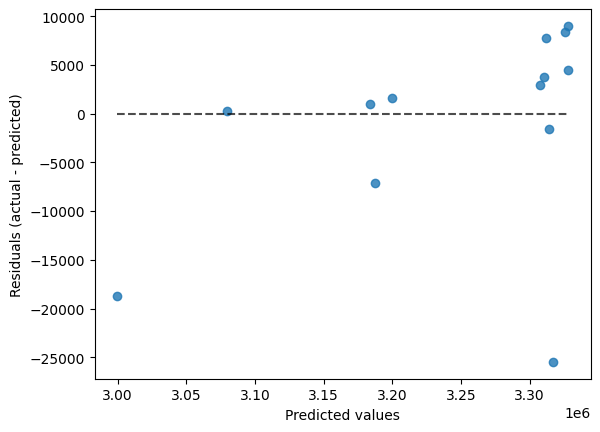

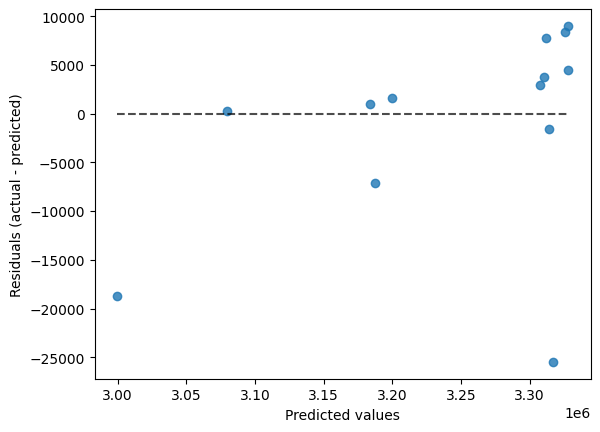

In [45]:
from sklearn import metrics
import numpy as np

predictions = session.call('get_regression_model_prediction',
                    'GradientBoostingRegression.gz',
                    0.1)

json_predictions = json.loads(predictions)

y_true = np.array(json_predictions["Test_target"])
y_pred = np.array(json_predictions["Predicted_target"])

print("y_true")
print(y_true)
print("y_pred")
print(y_pred)

display = metrics.PredictionErrorDisplay.from_predictions(y_true=y_true, y_pred=y_pred)
display.plot()
